# Stellar Populations in the Solar Neighborhood: A Gaia DR3 Color-Magnitude Analysis

## Theoretical Background
### The Hertzsprung-Russell Diagram
The Hertzsprung-Russell (HR) diagram relates stellar luminosity and temperature. In observational form, this is approximated by plotting:
- Absolute magnitude (proxy for luminosity)
- Color index (proxy for effective temperature)

For Gaia:
- Absolute G magnitude ≈ luminosity
- BP − RP ≈ temperature

Stellar structure theory predicts:
- Main sequence: hydrogen-burning stars in hydrostatic equilibrium
- Red giants: post-main-sequence expansion due to shell burning
- White dwarfs: compact cooling remnants

The location of a star in the HR diagram is governed by:
- Mass (primary parameter)
- Age
- Chemical composition

The nearby stellar population is expected to be dominated by low-mass main-sequence stars due to:
- The initial mass function (IMF)
- Longer lifetimes of low-mass stars

### Observational Assumptions

1. Distance is computed via simple inversion:

$$
d = \frac{1000}{\varpi}
$$

This approximation is valid for high signal-to-noise parallaxes (SNR > 10).

2. No extinction correction is applied. Because the sample is limited to $ \lesssim 200 \ \text{pc} $, interstellar reddening is expected to be modest.

3. The selection is only approximately volume-limited and remains affected by Gaia’s magnitude limits.

In [1]:
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Select nearby stars (parallax > 5 mas ≈ distance < 200 pc)
# Limiting to 1000 rows for quick exploratory analysis
query = """
SELECT TOP 1000
    source_id,
    ra,
    dec,
    parallax,
    parallax_error,
    phot_g_mean_mag,
    bp_rp
FROM gaiadr3.gaia_source
WHERE parallax > 5
"""
job = Gaia.launch_job(query)
results = job.get_results()

len(results)

1000

In [3]:
results.colnames
results[:5]

source_id,ra,dec,parallax,parallax_error,phot_g_mean_mag,bp_rp
,deg,deg,mas,mas,mag,mag
int64,float64,float64,float64,float32,float32,float32
320718093802368,44.74536901303269,1.0773950153983158,6.531837516382235,0.017344039,10.044208,0.7852421
550447304258304,44.79588627642886,2.0810457896532406,6.086675673256644,0.035279285,15.383587,2.3790636
583054696059392,46.303562089568544,1.4556487221932426,11.407273455939103,0.08725079,16.580158,3.2336245
640710336995072,46.128743548909256,1.725257074618689,5.7687712749591595,0.05386916,16.127031,2.5860262
768494203684224,47.571800043187416,2.556381532771415,5.0099411658666355,1.7005705,20.679522,1.9684887


In [4]:
# Basic finite-value mask
mask = (
    np.isfinite(results['parallax']) &
    np.isfinite(results['phot_g_mean_mag']) &
    np.isfinite(results['bp_rp'])
)

clean = results[mask]

# Apply parallax signal-to-noise cut to ensure reliable distance estimates
# SNR > 10 is commonly used to justify simple parallax inversion
snr_mask = clean['parallax'] / clean['parallax_error'] > 10
clean = clean[snr_mask]

len(clean)
print(f"Final sample size: {len(clean)} stars")

Final sample size: 869 stars


In [5]:
# Convert parallax (mas) to distance in parsecs via simple inversion
# Valid for high-SNR parallaxes; ignores Bayesian distance corrections
parallax = clean['parallax']  # mas
distance_pc = 1000 / parallax

G = clean['phot_g_mean_mag']
# Compute absolute magnitude using distance modulus
abs_G = G - 5 * np.log10(distance_pc) + 5

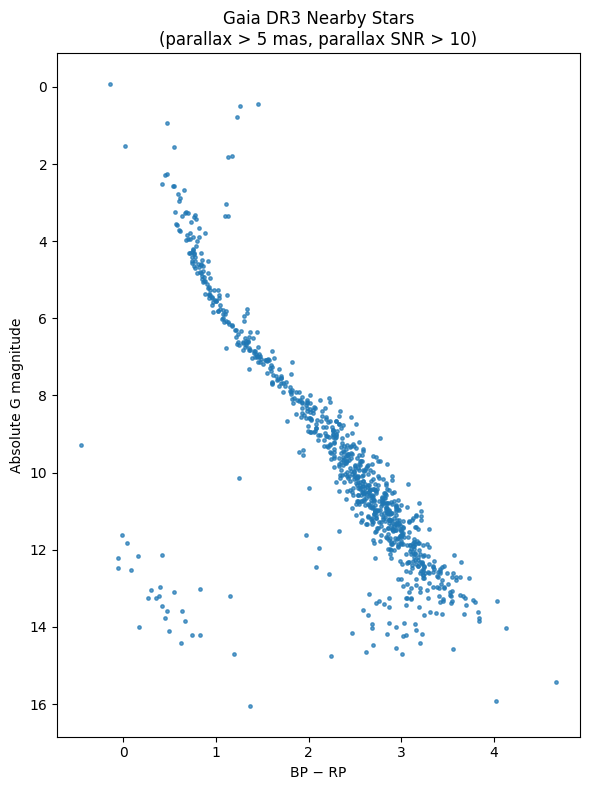

In [6]:
plt.figure(figsize=(6,8))
plt.scatter(clean['bp_rp'], abs_G, s=6, alpha=0.7)
plt.gca().invert_yaxis() # Invert y-axis because brighter stars have lower magnitudes
plt.xlabel('BP − RP')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia DR3 Nearby Stars\n(parallax > 5 mas, parallax SNR > 10)')
plt.tight_layout()
plt.show()

## Data Selection

The Gaia DR3 archive was queried using ADQL to select 1000 sources with:

- Parallax > 5 mas (distance ≲ 200 pc)
- Finite astrometric and photometric measurements
- Parallax signal-to-noise ratio > 10

After applying quality cuts, the final working sample contains 878 stars.

These cuts reduce distance uncertainty and minimize contamination from poorly measured sources.

## Interpretation of the Color-Magnitude Diagram

The diagram shows a well-defined main sequence extending from:

- **Blue, luminous stars** (low BP - RP, low absolute magnitude)  
- To **red, faint stars** (high BP - RP, high absolute magnitude)

This structure reflects fundamental predictions of stellar structure theory.

### Mass-Luminosity Relation

Because luminosity spans several orders of magnitude across the main sequence, even modest differences in stellar mass translate into large vertical separations in absolute magnitude.

The narrowness of the observed main sequence suggests relatively small observational uncertainties after applying the parallax SNR cut.

Main-sequence stars approximately follow a mass-luminosity relation:

$$
L \propto M^{\alpha}
$$

where for solar-type stars,

$$
\alpha \sim 3 - 4
$$

This implies that small increases in stellar mass produce large increases in luminosity, explaining the steep vertical structure of the main sequence.

### Stellar Population Effects

The dominance of red, low-luminosity stars reflects the **initial mass function (IMF)**, which favors the formation of low-mass stars.

A sparse population above the main sequence likely corresponds to evolved subgiant and red giant stars.

The relative absence of very massive blue stars is expected because:

- They are intrinsically rare (IMF effect)
- They have short evolutionary lifetimes

Thus, the observed color-magnitude diagram is a direct empirical imprint of stellar evolution theory combined with Galactic star formation history.

## Limitations and Future Work

### Current Limitations
- No extinction correction
- No metallicity analysis
- No kinematic separation of disk and halo populations
- Simple parallax inversion

### Kinematic Extension

The tangential velocity of a star can be estimated from proper motion and parallax:

$$
v_t = 4.74 \frac{\mu}{\varpi}
$$

This will allow future separation of thin disk, thick disk, and halo populations.